In [1]:
import sys
sys.path.insert(1, '/home/nicolas/Documents/Stage/code/stage/src')
import torch
import rbm
import functions
import numpy as np
import gzip
import pickle
device = torch.device("cuda")
dtype = torch.float

In [2]:
fname = 'model/AllParametersTESTCV2_LongRUNExMC_NS10000_TEMP_0_MNIST_Nh500_lr0.01_l20_NGibbs10000.h5'
myRBM, f, alltimes = functions.retrieveRBM(device, fname)
#index_random = torch.randint(0,len(alltimes),(100,))
#index_random = len(alltimes)-1
index_random = -1

In [3]:
all_si = []
for t in [np.array(alltimes)[index_random]]:
    myRBM.W = torch.tensor(f['paramW'+str(t)], device = myRBM.device)
    myRBM.vbias = torch.tensor(f['paramVB'+str(t)], device = myRBM.device)
    myRBM.hbias = torch.tensor(f['paramHB'+str(t)], device = myRBM.device)
    vinit = torch.bernoulli(torch.rand((myRBM.Nv,10000), device=myRBM.device, dtype=myRBM.dtype))
    
    si,mi,_,_ = myRBM.Sampling(vinit,it_mcmc=10000)#,anneal_steps=0)
    all_si.append(si)


In [4]:
data_gen = torch.cat(all_si, dim=1)
data_gen = data_gen.T
torch.save(data_gen, "data/data_gen.pt")

In [7]:
f = gzip.open('./data/mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, _, _ = p
data_mnist = torch.as_tensor(train_set[0][:10000,:].T, device = device, dtype = dtype)
data_minst = data_mnist.T
torch.save(data_gen, "data/data_MNIST.pt")

In [4]:
data_gen = torch.cat(all_si, dim=1)
f = gzip.open('./data/mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, _, _ = p

data_mnist = torch.as_tensor(train_set[0][:10000,:].T, device = device, dtype = dtype)

In [5]:
labels_gen = torch.tensor(np.ones(len(data_gen[0])), device = device)
labels_mnist = torch.tensor(np.zeros(len(data_mnist[0])), device = device)

data = torch.cat((data_gen, data_mnist), dim = 1)
labels = torch.cat((labels_gen, labels_mnist), dim = 0)

In [6]:
data = data.T
shuffle_index = torch.randperm(data.shape[0])


In [7]:
newdata = torch.empty(data.shape)
newlabel = torch.empty(labels.shape)
for i in range(shuffle_index.shape[0]):
    newdata[i] = data[shuffle_index[i]]
    newlabel[i] = labels[shuffle_index[i]]

In [8]:
torch.save(newdata, "data/data_10_updates.pt")
torch.save(newlabel, "data/labels_10_updates.pt")

In [9]:
newdata.shape

torch.Size([20000, 784])

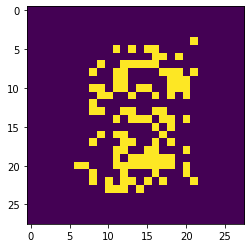

In [11]:
import matplotlib.pyplot as plt
plt.imshow(newdata[0].view(28,28).cpu())